In [1]:
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

In [3]:
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
data = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding =DATASET_ENCODING , names=DATASET_COLUMNS)
data.head()
X = data.iloc[:,[5]]
Y = data.iloc[:,0]
Y[Y == 4] = 1

C:\Users\Ansh Choudhary\AppData\Local\Temp\ipykernel_19424\3557809948.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y[Y == 4] = 1


In [4]:
data.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
# Text-preprocessing

# Missing Values
num_missing_desc = data.isnull().sum()[2]    # No. of values with msising descriptions
print('Number of missing values: ' + str(num_missing_desc))
data = data.dropna()

TAG_CLEANING_RE = r"@\S+"
# Remove @tags
X['text'] = X['text'].map(lambda x: re.sub(TAG_CLEANING_RE, ' ', x))

# Smart lowercase
X['text'] = X['text'].map(lambda x: x.lower())

# Remove numbers
X['text'] = X['text'].map(lambda x: re.sub(r'\d+', ' ', x))

# Remove links
TEXT_CLEANING_RE = r"https?:\S+|http?:\S|[^A-Za-z0-9]+"
X['text'] = X['text'].map(lambda x: re.sub(TEXT_CLEANING_RE, ' ', x))

# Remove Punctuation
X['text']  = X['text'].map(lambda x: x.translate(x.maketrans('', '', string.punctuation)))

# Remove white spaces
X['text'] = X['text'].map(lambda x: x.strip())

# Tokenize into words
X['text'] = X['text'].map(lambda x: word_tokenize(x))
 
# Remove non alphabetic tokens
X['text'] = X['text'].map(lambda x: [word for word in x if word.isalpha()])

# Filter out stop words
stop_words = set(stopwords.words('english'))
X['text'] = X['text'].map(lambda x: [w for w in x if not w in stop_words])
    
# Word Lemmatization
lem = WordNetLemmatizer()
X['text'] = X['text'].map(lambda x: [lem.lemmatize(word,"v") for word in x])

# Turn lists back to string
X['text'] = X['text'].map(lambda x: ' '.join(x))

C:\Users\Ansh Choudhary\AppData\Local\Temp\ipykernel_19424\3970937032.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  num_missing_desc = data.isnull().sum()[2]    # No. of values with msising descriptions


Number of missing values: 0


In [6]:
X.head()

,text
0,zl awww bummer shoulda get david carr third day
1,upset update facebook texting might cry result...
2,dive many time ball manage save rest go bound
3,whole body feel itchy like fire
4,behave mad see


In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print("TRAIN size:", len(X_train))
print("TEST size:", len(X_test))

TRAIN size: 1280000
TEST size: 320000


Flow 
- Pre-processing
- create word2vec
- tokenize and padding
- model creation
- testing

In [8]:
# Word2Vec
import gensim

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

documents = [_text.split() for _text in X_train.text] 
w2v_model = gensim.models.word2vec.Word2Vec(vector_size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)
w2v_model.build_vocab(documents)

In [9]:
words = list(w2v_model.wv.key_to_index.keys())
vocab_size = len(words)
print("Vocab size:", vocab_size)


Vocab size: 25276


In [10]:
# Train Word Embeddings
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

(251363176, 289225504)

In [11]:
#Test word embeddings
w2v_model.wv.most_similar("great")

[('fantastic', 0.7284249067306519),
 ('wonderful', 0.725797176361084),
 ('good', 0.6926975250244141),
 ('awesome', 0.6710512638092041),
 ('amaze', 0.6250723600387573),
 ('fabulous', 0.5921127200126648),
 ('excellent', 0.5869541764259338),
 ('fab', 0.5798591375350952),
 ('nice', 0.5679015517234802),
 ('lovely', 0.5412894487380981)]

In [12]:
# Tokenizing
import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout
#from tensorflow.keras.utils.np_utils import to_categorical
from tensorflow.keras.utils import to_categorical

# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 300
# This is fixed.
EMBEDDING_DIM = 300

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train.text)
word_index = tokenizer.word_index
vocab_size = len(word_index)
print('Found %s unique tokens.' % len(word_index))

# Convert the data to padded sequences
X_train_padded = tokenizer.texts_to_sequences(X_train.text)
X_train_padded = pad_sequences(X_train_padded, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_train_padded.shape)

Found 232838 unique tokens.
Shape of data tensor: (1280000, 300)


In [13]:
# saving
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [14]:
# Embedding matrix for the embedding layer
embedding_matrix = np.zeros((vocab_size+1, W2V_SIZE))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(232839, 300)


In [17]:
'''
# Build Model
import keras 

model = Sequential()
model.add(Embedding(vocab_size+1, W2V_SIZE, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])
'''


C:\Users\ehsaa\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │      69,851,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 69,851,700 (266.46 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 69,851,700 (266.46 MB)

In [19]:
import keras
from keras.callbacks import ReduceLROnPlateau

# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_lr=1e-7)

# Define a list to hold callbacks
callbacks = []

# Add the callback to the list of callbacks
callbacks.append(reduce_lr)


In [20]:
from keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# Add the callback to the list of callbacks
callbacks.append(early_stop)


In [21]:
import keras
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

# Define the model
model = Sequential()
model.add(Embedding(vocab_size+1, W2V_SIZE, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=True))  # Set trainable to True
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))  # Add return_sequences=True
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))  # Add an additional LSTM layer
model.add(Dense(64, activation='relu'))  # Add a dense layer with ReLU activation
model.add(Dropout(0.5))  # Add dropout layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=0.0001),  # Lower learning rate
              metrics=['accuracy'])


In [23]:
'''from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

model = Sequential()
model.add(Embedding(vocab_size+1, W2V_SIZE, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=True)) # Changed trainable to True
model.add(Dropout(0.5))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2)) # Increased LSTM units to 128
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

BATCH_SIZE = 512  # Define the batch size
epochs = 20

# Train the model
history = model.fit(X_train_padded, y_train, batch_size=BATCH_SIZE, epochs=epochs, validation_split=0.1, callbacks=callbacks)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ ?                           │      69,851,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 69,851,700 (266.46 MB)

 Trainable params: 69,851,700 (266.46 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 2520s 1s/step - accuracy: 0.7415 - loss: 0.5145 - val_accuracy: 0.7834 - val_loss: 0.4580 - learning_rate: 0.0010
Epoch 2/20
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 2574s 1s/step - accuracy: 0.7800 - loss: 0.4607 - val_accuracy: 0.7879 - val_loss: 0.4522 - learning_rate: 0.0010
Epoch 3/20
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 2688s 1s/step - accuracy: 0.7961 - loss: 0.4354 - val_accuracy: 0.7876 - val_loss: 0.4599 - learning_rate: 0.0010
Epoch 4/20
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 2690s 1s/step - accuracy: 0.8102 - loss: 0.4098 - val_accuracy: 0.7841 - val_loss: 0.4724 - learning_rate: 0.0010
Epoch 5/20
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8179 - loss: 0.3949
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 2664s 1s/step - accuracy: 0.8179 - loss: 0.3949 - val_accuracy: 0.7816 - val_loss: 0.4768 - learning_rate: 0.0010
Epoch 6/20
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 2617s 1s/step - accuracy:

In [25]:
'''
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# Define callbacks
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
    EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5),
    ModelCheckpoint('best_model.h5.keras', monitor='val_accuracy', save_best_only=True, mode='max')
]

# Define the model
model = Sequential()
model.add(Embedding(vocab_size+1, W2V_SIZE, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=True)) # Changed trainable to True
model.add(Dropout(0.5))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2)) # Increased LSTM units to 128
model.add(Dense(1, activation='sigmoid'))

model.summary()

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

BATCH_SIZE = 512  # Define the batch size
epochs = 20

# Train the model
history = model.fit(X_train_padded, y_train, batch_size=BATCH_SIZE, epochs=epochs, validation_split=0.1, callbacks=callbacks)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ ?                           │      69,851,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 69,851,700 (266.46 MB)

 Trainable params: 69,851,700 (266.46 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 2604s 1s/step - accuracy: 0.7433 - loss: 0.5125 - val_accuracy: 0.7827 - val_loss: 0.4581 - learning_rate: 0.0010
Epoch 2/20
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 2629s 1s/step - accuracy: 0.7795 - loss: 0.4604 - val_accuracy: 0.7880 - val_loss: 0.4531 - learning_rate: 0.0010
Epoch 3/20
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 2630s 1s/step - accuracy: 0.7969 - loss: 0.4338 - val_accuracy: 0.7878 - val_loss: 0.4553 - learning_rate: 0.0010
Epoch 4/20
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 2637s 1s/step - accuracy: 0.8107 - loss: 0.4100 - val_accuracy: 0.7851 - val_loss: 0.4677 - learning_rate: 0.0010
Epoch 5/20
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 2645s 1s/step - accuracy: 0.8197 - loss: 0.3936 - val_accuracy: 0.7829 - val_loss: 0.4763 - learning_rate: 0.0010
Epoch 6/20
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 2639s 1s/step - accuracy: 0.8230 - loss: 0.3851 - val_accuracy: 0.7827 - val_loss: 0.4902 - learning_rate: 0.0010
Epoch 7/20
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 2662s 1s/step - accura

In [27]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.callbacks import ModelCheckpoint

model = Sequential()
model.add(Embedding(vocab_size+1, W2V_SIZE, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=True))
model.add(Dropout(0.5))
model.add(LSTM(128, dropout=0.5, recurrent_dropout=0.5))  # Increased dropout rate
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=0.0001),  # Lower learning rate
              metrics=['accuracy'])

BATCH_SIZE = 512  
epochs = 20

# Define a callback to save the model
checkpoint_filepath = 'best_model2.h5.keras'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# Train the model with the callback
history = model.fit(X_train_padded, y_train, batch_size=BATCH_SIZE, epochs=epochs, validation_split=0.1, callbacks=[model_checkpoint_callback])


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)              │ ?                           │      69,851,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 69,851,700 (266.46 MB)

 Trainable params: 69,851,700 (266.46 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 2627s 1s/step - accuracy: 0.6673 - loss: 0.5998 - val_accuracy: 0.7561 - val_loss: 0.5224
Epoch 2/20
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 2645s 1s/step - accuracy: 0.7257 - loss: 0.5383 - val_accuracy: 0.7639 - val_loss: 0.5028
Epoch 3/20
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 2632s 1s/step - accuracy: 0.7378 - loss: 0.5223 - val_accuracy: 0.7669 - val_loss: 0.4981
Epoch 4/20
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 2638s 1s/step - accuracy: 0.7446 - loss: 0.5118 - val_accuracy: 0.7691 - val_loss: 0.4891
Epoch 5/20
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 2645s 1s/step - accuracy: 0.7496 - loss: 0.5052 - val_accuracy: 0.7719 - val_loss: 0.4831
Epoch 6/20
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 2652s 1s/step - accuracy: 0.7542 - loss: 0.4990 - val_accuracy: 0.7730 - val_loss: 0.4794
Epoch 7/20
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 2795s 1s/step - accuracy: 0.7570 - loss: 0.4944 - val_accuracy: 0.7747 - val_loss: 0.4767
Epoch 8/20
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 2724s 1s/step - accuracy: 0.7597 -

In [15]:
# Load Model
from keras.models import load_model
model = load_model("best_model.h5.keras")

In [16]:
# Load Model
from keras.models import load_model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load the model
model = load_model('best_model.h5.keras')  # Assuming the model file is in the same directory

# Tokenize and pad the test data
X_test_padded = tokenizer.texts_to_sequences(X_test['text'])
X_test_padded = pad_sequences(X_test_padded, maxlen=MAX_SEQUENCE_LENGTH)

# Predictions
y_pred = model.predict(X_test_padded)
y_pred = (y_pred > 0.5)  # Convert probabilities to binary predictions

# Convert to binary labels
y_test_binary = (y_test == 1)

# Accuracy
accuracy = accuracy_score(y_test_binary, y_pred)
print("Accuracy:", accuracy)

# Classification Report
print("Classification Report:")
print(classification_report(y_test_binary, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_binary, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 1434s 142ms/step
Accuracy: 0.788803125
Classification Report:
              precision    recall  f1-score   support

       False       0.79      0.78      0.79    159494
        True       0.78      0.80      0.79    160506

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000

Confusion Matrix:
[[123941  35553]
 [ 32030 128476]]


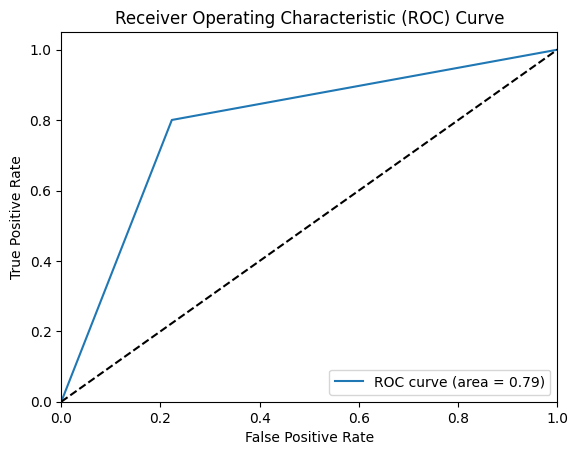

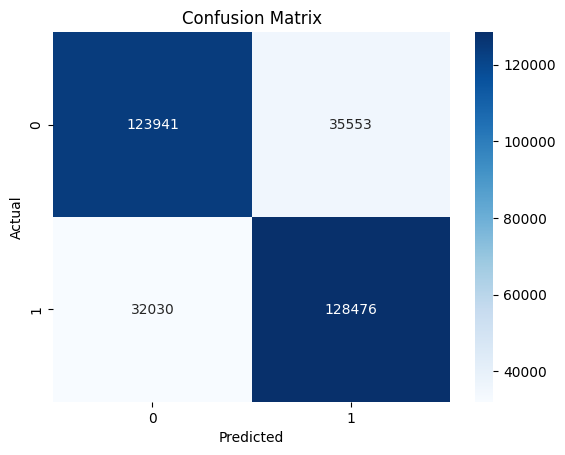

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve

# ROC AUC Curve
roc_auc = roc_auc_score(y_test_binary, y_pred)
fpr, tpr, thresholds = roc_curve(y_test_binary, y_pred)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix Plot
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [13]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Predict probabilities for the test data
y_pred_prob = model.predict(X_test_padded)

# Initialize variables to store best threshold and corresponding metrics
best_threshold = 0
best_f1_score = 0
best_precision = 0
best_recall = 0

# Vary the threshold from 0 to 1
for threshold in np.arange(0, 1.01, 0.01):
    # Convert probabilities to binary predictions based on the threshold
    y_pred = (y_pred_prob > threshold).astype(int)
    
    # Calculate precision, recall, and F1-score
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Check if the current F1-score is better than the best F1-score
    if f1 > best_f1_score:
        best_threshold = threshold
        best_f1_score = f1
        best_precision = precision
        best_recall = recall

print("Best Threshold:", best_threshold)
print("Best F1-score:", best_f1_score)
print("Best Precision:", best_precision)
print("Best Recall:", best_recall)


10000/10000 ━━━━━━━━━━━━━━━━━━━━ 1257s 126ms/step


C:\Users\Ansh Choudhary\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Best Threshold: 0.4
Best F1-score: 0.7973822340094149
Best Precision: 0.748389282650156
Best Recall: 0.85323913124743


In [19]:
# Convert probabilities to binary predictions based on the best threshold
y_pred_final = (y_pred_prob > best_threshold).astype(int)

# Print classification report and confusion matrix for the final predictions
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:")
print(classification_report(y_test, y_pred_final))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_final))


Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.71      0.77    159494
           1       0.75      0.85      0.80    160506

    accuracy                           0.78    320000
   macro avg       0.79      0.78      0.78    320000
weighted avg       0.79      0.78      0.78    320000

Confusion Matrix:
[[113451  46043]
 [ 23556 136950]]


In [20]:
# Generate predicted probabilities using the loaded model
y_pred_proba = model.predict(X_test_padded).ravel()

# Threshold Adjustment
thresholds = np.arange(0.1, 1.0, 0.1)
best_threshold = 0
best_f1_score = 0

for threshold in thresholds:
    y_pred = (y_pred_proba >= threshold).astype(int)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    
    if f1 > best_f1_score:
        best_f1_score = f1
        best_threshold = threshold

print("Best Threshold:", best_threshold)
print("Best F1-score:", best_f1_score)


10000/10000 ━━━━━━━━━━━━━━━━━━━━ 1234s 123ms/step
Best Threshold: 0.4
Best F1-score: 0.7973822340094149


Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.71      0.77    159494
           1       0.75      0.85      0.80    160506

    accuracy                           0.78    320000
   macro avg       0.79      0.78      0.78    320000
weighted avg       0.79      0.78      0.78    320000



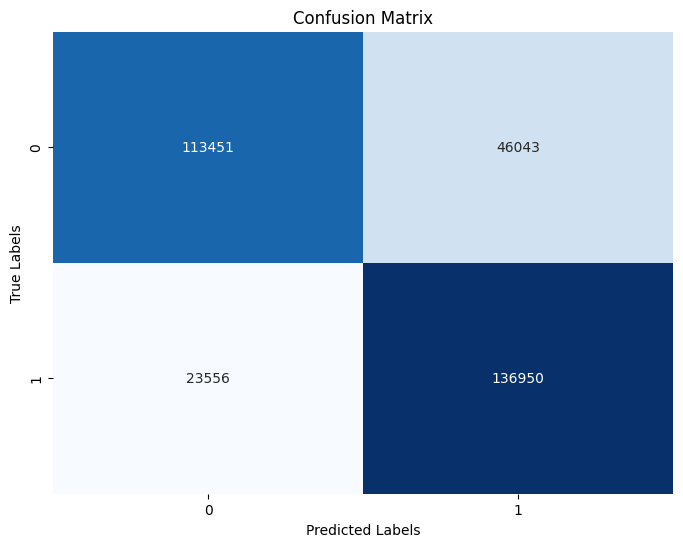

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Set the threshold
threshold = 0.4

# Predict using the chosen threshold
y_pred = (y_pred_proba >= threshold).astype(int)

# Generate classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [22]:
# Evaluation
import matplotlib.pyplot as plt
X_test_padded = tokenizer.texts_to_sequences(X_test.text)
X_test_padded = pad_sequences(X_test_padded, maxlen=MAX_SEQUENCE_LENGTH)
score = model.evaluate(X_test_padded, y_test, batch_size=512)
print("ACCURACY:",score[1])
print("LOSS:",score[0])

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

625/625 ━━━━━━━━━━━━━━━━━━━━ 1013s 2s/step - accuracy: 0.7894 - loss: 0.4504
ACCURACY: 0.7888031005859375
LOSS: 0.45199155807495117


NameError: name 'history' is not defined

In [23]:
def predict(text, include_neutral=True):
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=MAX_SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    if(score >=0.4 and score<=0.6):
        label = "Neutral"
    if(score <=0.4):
        label = "Negative"
    if(score >=0.6):
        label = "Positive"

    return {"label" : label,
        "score": float(score)}  

In [24]:
predict("she went outside. it was raining and she was happy. but she had to come back home so that made her sad")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


C:\Users\Ansh Choudhary\AppData\Local\Temp\ipykernel_19424\3279050681.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "score": float(score)}


{'label': 'Negative', 'score': 0.014391923323273659}

In [29]:
predict("Today is my birthday and I am very excited for it!")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


C:\Users\Ansh Choudhary\AppData\Local\Temp\ipykernel_19424\3279050681.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "score": float(score)}


{'label': 'Positive', 'score': 0.932337760925293}

In [27]:
predict("Today is a good day!")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


C:\Users\Ansh Choudhary\AppData\Local\Temp\ipykernel_19424\3279050681.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "score": float(score)}


{'label': 'Positive', 'score': 0.9070379137992859}

In [30]:
predict("i had my presentation today, and it didnt go very well but my faculty is happy with my work!")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


C:\Users\Ansh Choudhary\AppData\Local\Temp\ipykernel_19424\3279050681.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "score": float(score)}


{'label': 'Neutral', 'score': 0.4371005892753601}

In [32]:
predict("This is my final year project, its my last day in college and i will miss coming here!")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


C:\Users\Ansh Choudhary\AppData\Local\Temp\ipykernel_19424\3279050681.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "score": float(score)}


{'label': 'Negative', 'score': 0.11804913729429245}